In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from pathlib import Path
from typing import Any, Dict, List, Optional

In [2]:
ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data"
SOURCE_DIR = DATA_DIR / "source"
OUTPUT_DIR = DATA_DIR / "output"
INPUT_PATH = SOURCE_DIR / "OE_Public_Match_Data_cleaned.csv"

In [3]:
df = pd.read_csv(INPUT_PATH)
df.head()

,firsttothreetowers,firstbaron,xpdiffat,firstmidtower,golddiffat,diffkillsat,firstdragon,diffdeathsat,firsttower,firstblood,...,side,diffassistsat,split_Regular,split_Special,playoffs,firstherald,game,patch,minute,result
0,1.0,1.0,-463.0,1.0,-119.0,1.0,0.0,-1.0,1.0,1.0,...,1,3.0,1,0,0,0.0,1.0,3.15,10,1
1,1.0,1.0,63.0,1.0,1272.0,2.0,0.0,-2.0,1.0,1.0,...,1,4.0,1,0,0,0.0,1.0,3.15,15,1
2,1.0,1.0,825.0,1.0,2036.0,2.0,0.0,-2.0,1.0,1.0,...,1,4.0,1,0,0,0.0,1.0,3.15,20,1
3,1.0,1.0,4919.0,1.0,4854.0,6.0,0.0,-6.0,1.0,1.0,...,1,17.0,1,0,0,0.0,1.0,3.15,25,1
4,0.0,0.0,463.0,0.0,119.0,-1.0,1.0,1.0,0.0,0.0,...,0,-3.0,1,0,0,0.0,1.0,3.15,10,0


In [4]:
feature_columns = [col for col in df.columns if col != 'result']
X = df[feature_columns].values
y = df['result'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {np.bincount(y)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train_scaled.shape}, {y_train.shape}")
print(f"Validation set: {X_val_scaled.shape}, {y_val.shape}")
print(f"Test set: {X_test_scaled.shape}, {y_test.shape}")

Features shape: (731240, 20)
Target shape: (731240,)
Target distribution: [365792 365448]
Train set: (438744, 20), (438744,)
Validation set: (146248, 20), (146248,)
Test set: (146248, 20), (146248,)


In [5]:
class LogisticRegression:
    def __init__(self):
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y):
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return loss

    def _compute_gradient(self, X, y):
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        dw = (1 / len(y)) * X.T @ (predictions - y)
        db = (1 / len(y)) * np.sum(predictions - y)
        return dw, db

    def predict_proba(self, X):
        z = X @ self.weights + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [6]:
class SGDOptimizer:
    """
    Stochastic Gradient Descent optimizer with early stopping and logging capabilities.
    
    Features:
    - Fixed learning rate
    - Early stopping based on loss improvement threshold
    - Configurable logging intervals
    - Loss history tracking
    """
    
    def __init__(self, learning_rate=0.01, max_epochs=1000, early_stop_patience=50, 
                 early_stop_threshold=1e-6, log_interval=10, verbose=True):
        """
        Initialize SGD optimizer.
        
        Args:
            learning_rate (float): Fixed learning rate for gradient descent
            max_epochs (int): Maximum number of training epochs
            early_stop_patience (int): Number of epochs to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n epochs
            verbose (bool): Whether to print training progress
        """
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.epoch_history = []
        self.stopped_early = False
        self.final_epoch = 0
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None):
        """
        Optimize model parameters using SGD with early stopping.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Track best loss for early stopping
        best_loss = float('inf')
        patience_counter = 0
        
        if self.verbose:
            print(f"Starting SGD training with learning rate: {self.learning_rate}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            print("-" * 60)
            
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            # Compute loss and gradients
            train_loss = model._compute_loss(X_train, y_train)
            dw, db = model._compute_gradient(X_train, y_train)
            
            # Update parameters
            model.weights -= self.learning_rate * dw
            model.bias -= self.learning_rate * db
            
            # Store history
            self.loss_history.append(train_loss)
            self.epoch_history.append(epoch)
            
            # Check for early stopping
            if train_loss < best_loss - self.early_stop_threshold:
                best_loss = train_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Log progress
            if (epoch + 1) % self.log_interval == 0 and self.verbose:
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = model._compute_loss(X_val, y_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f}{val_loss_str} | "
                      f"LR: {self.learning_rate:.4f} | Patience: {patience_counter:2d}/{self.early_stop_patience} | "
                      f"Time: {elapsed_time:.2f}s")
                
            # Early stopping check
            if patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_epoch = epoch + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} epochs "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_epoch = self.max_epochs
            if self.verbose:
                print(f"\nTraining completed after {self.max_epochs} epochs")
                
        training_time = time.time() - start_time
        final_loss = self.loss_history[-1]
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per epoch: {training_time/self.final_epoch:.4f}s")
            
        return {
            'loss_history': self.loss_history.copy(),
            'epoch_history': self.epoch_history.copy(),
            'final_loss': final_loss,
            'final_epoch': self.final_epoch,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'learning_rate': self.learning_rate
        }
    
    def plot_loss_curve(self, title="SGD Loss Curve"):
        """Plot the loss curve from training history."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        plt.figure(figsize=(10, 6))
        plt.plot(self.epoch_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{title} (LR: {self.learning_rate})')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        if self.stopped_early:
            plt.axvline(x=self.final_epoch-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Epoch {self.final_epoch})')
            plt.legend()
            
        plt.tight_layout()
        plt.show()

In [7]:
class SGDBacktrackingOptimizer:
    """
    Stochastic Gradient Descent with Backtracking Line Search.
    
    Features:
    - Adaptive step size using Armijo line search condition
    - Backtracking algorithm with configurable parameters
    - Early stopping based on loss improvement threshold
    - Configurable logging intervals
    - Step size history tracking
    """
    
    def __init__(self, initial_learning_rate=1.0, c1=1e-4, rho=0.5, max_epochs=1000, 
                 early_stop_patience=50, early_stop_threshold=1e-6, log_interval=10, 
                 max_backtrack_iter=20, verbose=True):
        """
        Initialize SGD Backtracking optimizer.
        
        Args:
            initial_learning_rate (float): Initial step size for backtracking
            c1 (float): Armijo condition parameter (0 < c1 < 1)
            rho (float): Step size reduction factor (0 < rho < 1)
            max_epochs (int): Maximum number of training epochs
            early_stop_patience (int): Number of epochs to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n epochs
            max_backtrack_iter (int): Maximum backtracking iterations per epoch
            verbose (bool): Whether to print training progress
        """
        self.initial_learning_rate = initial_learning_rate
        self.c1 = c1  # Armijo parameter
        self.rho = rho  # Step reduction factor
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.max_backtrack_iter = max_backtrack_iter
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.epoch_history = []
        self.step_size_history = []
        self.backtrack_iterations_history = []
        self.stopped_early = False
        self.final_epoch = 0
        
    def _armijo_condition(self, f_current, f_new, grad_dot_direction, step_size):
        """
        Check Armijo sufficient decrease condition.
        
        Args:
            f_current: Current function value
            f_new: New function value after step
            grad_dot_direction: Gradient dot product with search direction
            step_size: Current step size
            
        Returns:
            bool: True if Armijo condition is satisfied
        """
        return f_new <= f_current + self.c1 * step_size * grad_dot_direction
    
    def _backtracking_line_search(self, model, X, y, current_weights, current_bias, 
                                  dw, db, current_loss):
        """
        Perform backtracking line search to find suitable step size.
        
        Args:
            model: Model object
            X: Input features
            y: Target values
            current_weights: Current weight parameters
            current_bias: Current bias parameter
            dw: Weight gradients
            db: Bias gradient
            current_loss: Current loss value
            
        Returns:
            tuple: (step_size, backtrack_iterations)
        """
        step_size = self.initial_learning_rate
        
        # Compute gradient norm squared (for descent direction)
        grad_norm_sq = np.sum(dw**2) + db**2
        
        # Search direction is negative gradient
        direction_dot_grad = -grad_norm_sq
        
        backtrack_iter = 0
        
        for i in range(self.max_backtrack_iter):
            # Try step with current step size
            new_weights = current_weights - step_size * dw
            new_bias = current_bias - step_size * db
            
            # Temporarily update model parameters to compute new loss
            old_weights = model.weights.copy()
            old_bias = model.bias
            
            model.weights = new_weights
            model.bias = new_bias
            
            new_loss = model._compute_loss(X, y)
            
            # Restore original parameters
            model.weights = old_weights
            model.bias = old_bias
            
            # Check Armijo condition
            if self._armijo_condition(current_loss, new_loss, direction_dot_grad, step_size):
                break
                
            # Reduce step size
            step_size *= self.rho
            backtrack_iter += 1
            
        return step_size, backtrack_iter
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None):
        """
        Optimize model parameters using SGD with backtracking line search.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Track best loss for early stopping
        best_loss = float('inf')
        patience_counter = 0
        
        if self.verbose:
            print(f"Starting SGD with Backtracking Line Search")
            print(f"Initial step size: {self.initial_learning_rate}, c1: {self.c1}, rho: {self.rho}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            print("-" * 80)
            
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            # Compute loss and gradients
            train_loss = model._compute_loss(X_train, y_train)
            dw, db = model._compute_gradient(X_train, y_train)
            
            # Perform backtracking line search
            step_size, backtrack_iter = self._backtracking_line_search(
                model, X_train, y_train, model.weights, model.bias, dw, db, train_loss
            )
            
            # Update parameters with found step size
            model.weights -= step_size * dw
            model.bias -= step_size * db
            
            # Store history
            self.loss_history.append(train_loss)
            self.epoch_history.append(epoch)
            self.step_size_history.append(step_size)
            self.backtrack_iterations_history.append(backtrack_iter)
            
            # Check for early stopping
            if train_loss < best_loss - self.early_stop_threshold:
                best_loss = train_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Log progress
            if (epoch + 1) % self.log_interval == 0 and self.verbose:
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = model._compute_loss(X_val, y_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                avg_step_size = np.mean(self.step_size_history[-self.log_interval:])
                avg_backtrack = np.mean(self.backtrack_iterations_history[-self.log_interval:])
                
                print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f}{val_loss_str} | "
                      f"Step Size: {step_size:.6f} | Avg Step: {avg_step_size:.6f} | "
                      f"Backtrack: {backtrack_iter:2d} | Avg BT: {avg_backtrack:.1f} | "
                      f"Patience: {patience_counter:2d}/{self.early_stop_patience} | Time: {elapsed_time:.2f}s")
                
            # Early stopping check
            if patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_epoch = epoch + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} epochs "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_epoch = self.max_epochs
            if self.verbose:
                print(f"\nTraining completed after {self.max_epochs} epochs")
                
        training_time = time.time() - start_time
        final_loss = self.loss_history[-1]
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per epoch: {training_time/self.final_epoch:.4f}s")
            print(f"Average step size: {np.mean(self.step_size_history):.6f}")
            print(f"Final step size: {self.step_size_history[-1]:.6f}")
            print(f"Average backtrack iterations: {np.mean(self.backtrack_iterations_history):.2f}")
            
        return {
            'loss_history': self.loss_history.copy(),
            'epoch_history': self.epoch_history.copy(),
            'step_size_history': self.step_size_history.copy(),
            'backtrack_iterations_history': self.backtrack_iterations_history.copy(),
            'final_loss': final_loss,
            'final_epoch': self.final_epoch,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'initial_learning_rate': self.initial_learning_rate,
            'avg_step_size': np.mean(self.step_size_history),
            'final_step_size': self.step_size_history[-1],
            'avg_backtrack_iterations': np.mean(self.backtrack_iterations_history)
        }
    
    def plot_training_curves(self, title="SGD Backtracking Training Curves"):
        """Plot loss curve and step size evolution."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
        
        # Plot 1: Loss curve
        ax1.plot(self.epoch_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{title} - Loss Evolution')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        if self.stopped_early:
            ax1.axvline(x=self.final_epoch-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Epoch {self.final_epoch})')
            ax1.legend()
        
        # Plot 2: Step size evolution
        ax2.plot(self.epoch_history, self.step_size_history, 'g-', linewidth=2, label='Step Size')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Step Size')
        ax2.set_title('Step Size Evolution')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_yscale('log')  # Log scale for better visualization
        
        # Plot 3: Backtrack iterations
        ax3.plot(self.epoch_history, self.backtrack_iterations_history, 'r-', linewidth=2, 
                label='Backtrack Iterations')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Backtrack Iterations')
        ax3.set_title('Backtracking Iterations per Epoch')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
            
        plt.tight_layout()
        plt.show()

In [8]:
class LogisticRegressionSGDBacktrack:
    """
    Logistic Regression with SGD Backtracking Line Search optimization.
    """
    
    def __init__(self, optimizer=None):
        """
        Initialize logistic regression model with backtracking optimizer.
        
        Args:
            optimizer: SGDBacktrackingOptimizer instance. If None, uses default settings.
        """
        self.weights = None
        self.bias = None
        self.optimizer = optimizer or SGDBacktrackingOptimizer()
        self.training_history: Optional[Dict[str, Any]] = None
        
    def _sigmoid(self, z):
        """Sigmoid activation function with clipping for numerical stability."""
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y):
        """Compute logistic loss (cross-entropy)."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return loss

    def _compute_gradient(self, X, y):
        """Compute gradients for weights and bias."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        dw = (1 / len(y)) * X.T @ (predictions - y)
        db = (1 / len(y)) * np.sum(predictions - y)
        return dw, db
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using SGD with backtracking line search.
        
        Args:
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            
        Returns:
            self: Returns the fitted model
        """
        self.training_history = self.optimizer.optimize(
            self, X_train, y_train, X_val, y_val
        )
        return self

    def predict_proba(self, X):
        """Predict class probabilities."""
        if self.weights is None:
            raise ValueError("Model must be fitted before making predictions")
        z = X @ self.weights + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        """Predict class labels."""
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    def evaluate(self, X, y):
        """
        Evaluate model performance.
        
        Returns:
            dict: Dictionary containing loss and accuracy
        """
        if self.weights is None:
            raise ValueError("Model must be fitted before evaluation")
            
        loss = self._compute_loss(X, y)
        predictions = self.predict(X)
        accuracy = accuracy_score(y, predictions)
        
        return {
            'loss': loss,
            'accuracy': accuracy
        }
    
    def get_training_summary(self):
        """Get a summary of the training process."""
        if self.training_history is None:
            return "Model has not been trained yet."
            
        summary = f"""
Training Summary (SGD Backtracking):
===================================
Initial Step Size: {self.training_history['initial_learning_rate']:.6f}
Final Epoch: {self.training_history['final_epoch']}
Final Loss: {self.training_history['final_loss']:.6f}
Training Time: {self.training_history['training_time']:.2f}s
Early Stopping: {'Yes' if self.training_history['stopped_early'] else 'No'}
Average Time/Epoch: {self.training_history['training_time']/self.training_history['final_epoch']:.4f}s
Average Step Size: {self.training_history['avg_step_size']:.6f}
Final Step Size: {self.training_history['final_step_size']:.6f}
Average Backtrack Iterations: {self.training_history['avg_backtrack_iterations']:.2f}
"""
        return summary

In [9]:
class LogisticRegressionSGD:
    """
    Logistic Regression with SGD optimization and early stopping.
    """

    def __init__(self, optimizer=None):
        """
        Initialize logistic regression model.

        Args:
            optimizer: SGDOptimizer instance. If None, uses default SGD settings.
        """
        self.weights = None
        self.bias = None
        self.optimizer = optimizer or SGDOptimizer()
        self.training_history: Optional[Dict[str, Any]] = None

    def _sigmoid(self, z):
        """Sigmoid activation function with clipping for numerical stability."""
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y):
        """Compute logistic loss (cross-entropy)."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return loss

    def _compute_gradient(self, X, y):
        """Compute gradients for weights and bias."""
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        dw = (1 / len(y)) * X.T @ (predictions - y)
        db = (1 / len(y)) * np.sum(predictions - y)
        return dw, db

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using SGD optimization.

        Args:
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)

        Returns:
            self: Returns the fitted model
        """
        self.training_history = self.optimizer.optimize(
            self, X_train, y_train, X_val, y_val
        )
        return self

    def predict_proba(self, X):
        """Predict class probabilities."""
        if self.weights is None:
            raise ValueError("Model must be fitted before making predictions")
        z = X @ self.weights + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        """Predict class labels."""
        return (self.predict_proba(X) >= 0.5).astype(int)

    def evaluate(self, X, y):
        """
        Evaluate model performance.

        Returns:
            dict: Dictionary containing loss and accuracy
        """
        if self.weights is None:
            raise ValueError("Model must be fitted before evaluation")

        loss = self._compute_loss(X, y)
        predictions = self.predict(X)
        accuracy = accuracy_score(y, predictions)

        return {"loss": loss, "accuracy": accuracy}

    def get_training_summary(self):
        """Get a summary of the training process."""
        if self.training_history is None:
            return "Model has not been trained yet."

        summary = f"""
Training Summary:
================
Learning Rate: {self.training_history['learning_rate']:.6f}
Final Epoch: {self.training_history['final_epoch']}
Final Loss: {self.training_history['final_loss']:.6f}
Training Time: {self.training_history['training_time']:.2f}s
Early Stopping: {'Yes' if self.training_history['stopped_early'] else 'No'}
Average Time/Epoch: {self.training_history['training_time']/self.training_history['final_epoch']:.4f}s
"""
        return summary

In [12]:
# Test and compare SGD Fixed vs SGD Backtracking
def compare_sgd_methods():
    """
    Compare SGD with fixed learning rates vs SGD with backtracking line search.
    """
    print("Comparing SGD Methods: Fixed Learning Rate vs Backtracking")
    print("=" * 70)
    print()
    MAX_EPOCHS = 20000
    EARLY_STOP_THRESHOLD = 1e-6
    
    results = {}
    
    # Test 1: SGD with Fixed Learning Rates
    print("1. Testing SGD with Fixed Learning Rates")
    print("-" * 45)
    
    fixed_learning_rates = [0.01, 0.1, 0.5]
    
    for lr in fixed_learning_rates:
        print(f"\nTesting Fixed LR = {lr}")
        
        optimizer = SGDOptimizer(
            learning_rate=lr,
            max_epochs=MAX_EPOCHS,
            early_stop_patience=50,
            early_stop_threshold=EARLY_STOP_THRESHOLD,
            log_interval=50,
            verbose=True
        )
        
        model = LogisticRegressionSGD(optimizer=optimizer)
        
        start_time = time.time()
        model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
        total_time = time.time() - start_time
        
        # Evaluate performance
        train_metrics = model.evaluate(X_train_scaled, y_train)
        val_metrics = model.evaluate(X_val_scaled, y_val)
        test_metrics = model.evaluate(X_test_scaled, y_test)
        
        results[f'fixed_{lr}'] = {
            'method': f'Fixed LR {lr}',
            'model': model,
            'training_history': model.training_history,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'test_metrics': test_metrics,
            'total_time': total_time,
            'optimizer_type': 'fixed'
        }
        
        print(f"Results: Epochs={model.training_history['final_epoch']}, "
              f"Final Loss={train_metrics['loss']:.6f}, "
              f"Test Acc={test_metrics['accuracy']:.4f}, "
              f"Time={total_time:.2f}s")
    
    print("\n" + "="*70)
    print("2. Testing SGD with Backtracking Line Search")
    print("-" * 45)
    
    # Test 2: SGD with Backtracking (different initial step sizes)
    initial_step_sizes = [0.1, 1.0, 5.0]
    
    for initial_step in initial_step_sizes:
        print(f"\nTesting Backtracking with Initial Step = {initial_step}")
        
        optimizer = SGDBacktrackingOptimizer(
            initial_learning_rate=initial_step,
            c1=1e-4,
            rho=0.5,
            max_epochs=MAX_EPOCHS,
            early_stop_patience=50,
            early_stop_threshold=EARLY_STOP_THRESHOLD,
            log_interval=50,
            max_backtrack_iter=20,
            verbose=True
        )
        
        model = LogisticRegressionSGDBacktrack(optimizer=optimizer)
        
        start_time = time.time()
        model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
        total_time = time.time() - start_time
        
        # Evaluate performance
        train_metrics = model.evaluate(X_train_scaled, y_train)
        val_metrics = model.evaluate(X_val_scaled, y_val)
        test_metrics = model.evaluate(X_test_scaled, y_test)
        
        results[f'backtrack_{initial_step}'] = {
            'method': f'Backtrack Init {initial_step}',
            'model': model,
            'training_history': model.training_history,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'test_metrics': test_metrics,
            'total_time': total_time,
            'optimizer_type': 'backtrack'
        }
        
        print(f"Results: Epochs={model.training_history['final_epoch']}, "
              f"Final Loss={train_metrics['loss']:.6f}, "
              f"Test Acc={test_metrics['accuracy']:.4f}, "
              f"Time={total_time:.2f}s, "
              f"Avg Step={model.training_history['avg_step_size']:.6f}")
    
    return results

# Run the comparison
sgd_comparison_results = compare_sgd_methods()

Comparing SGD Methods: Fixed Learning Rate vs Backtracking

1. Testing SGD with Fixed Learning Rates
---------------------------------------------

Testing Fixed LR = 0.01
Starting SGD training with learning rate: 0.01
Early stopping: patience=50, threshold=1e-06
------------------------------------------------------------
Epoch   50 | Train Loss: 0.537627, Val Loss: 0.535946 | LR: 0.0100 | Patience:  0/50 | Time: 2.02s
Epoch  100 | Train Loss: 0.486795, Val Loss: 0.485932 | LR: 0.0100 | Patience:  0/50 | Time: 3.85s
Epoch  150 | Train Loss: 0.463014, Val Loss: 0.462413 | LR: 0.0100 | Patience:  0/50 | Time: 5.90s
Epoch  200 | Train Loss: 0.449429, Val Loss: 0.448946 | LR: 0.0100 | Patience:  0/50 | Time: 7.92s
Epoch  250 | Train Loss: 0.440623, Val Loss: 0.440208 | LR: 0.0100 | Patience:  0/50 | Time: 10.67s
Epoch  300 | Train Loss: 0.434395, Val Loss: 0.434027 | LR: 0.0100 | Patience:  0/50 | Time: 13.99s
Epoch  350 | Train Loss: 0.429707, Val Loss: 0.429377 | LR: 0.0100 | Patience: 

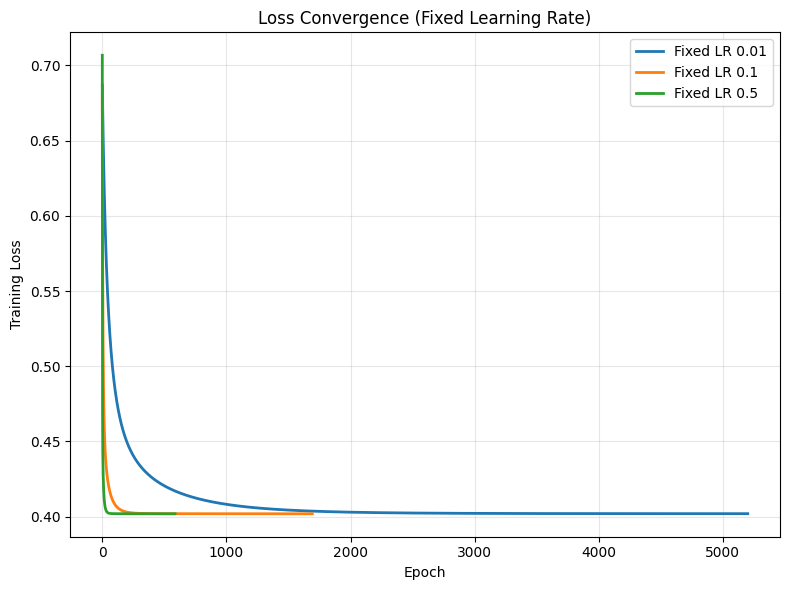

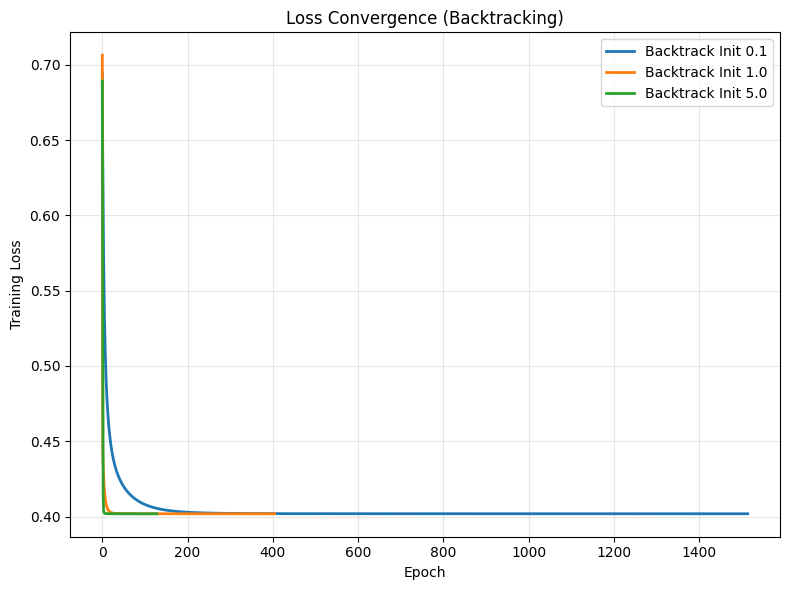

In [13]:
def plot_loss_convergence_separate(results):
    fixed_results = {k: v for k, v in results.items() if v["optimizer_type"] == "fixed"}
    backtrack_results = {
        k: v for k, v in results.items() if v["optimizer_type"] == "backtrack"
    }

    # Fixed learning rate
    plt.figure(figsize=(8, 6))
    for key, result in fixed_results.items():
        history = result["training_history"]
        plt.plot(
            history["epoch_history"],
            history["loss_history"],
            label=result["method"],
            linewidth=2,
        )
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Loss Convergence (Fixed Learning Rate)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Backtracking
    plt.figure(figsize=(8, 6))
    for key, result in backtrack_results.items():
        history = result["training_history"]
        plt.plot(
            history["epoch_history"],
            history["loss_history"],
            label=result["method"],
            linewidth=2,
        )
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Loss Convergence (Backtracking)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_loss_convergence_separate(sgd_comparison_results)

In [14]:
def plot_loss_convergence_separate(results):
    fixed_results = {k: v for k, v in results.items() if v["optimizer_type"] == "fixed"}
    backtrack_results = {
        k: v for k, v in results.items() if v["optimizer_type"] == "backtrack"
    }

    # Fixed learning rate
    plt.figure(figsize=(8, 6))
    for key, result in fixed_results.items():
        history = result["training_history"]
        plt.plot(
            history["epoch_history"],
            history["loss_history"],
            label=result["method"],
            linewidth=2,
        )
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Loss Convergence (Fixed Learning Rate)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "sgd" / "loss_fixed.png")
    plt.close()

    # Backtracking
    plt.figure(figsize=(8, 6))
    for key, result in backtrack_results.items():
        history = result["training_history"]
        plt.plot(
            history["epoch_history"],
            history["loss_history"],
            label=result["method"],
            linewidth=2,
        )
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Loss Convergence (Backtracking)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "sgd" / "loss_backtrack.png")
    plt.close()


plot_loss_convergence_separate(sgd_comparison_results)

In [8]:
# Test SGD with different fixed learning rates
def test_sgd_learning_rates():
    """
    Test SGD optimization with different fixed learning rates and compare performance.
    """
    # Different learning rates to test
    learning_rates = [0.01, 0.05, 0.1]

    # Store results for comparison
    results = {}

    print("Testing SGD with Different Fixed Learning Rates")
    print("=" * 60)
    print()

    for lr in learning_rates:
        print(f"Training with Learning Rate: {lr}")
        print("-" * 40)

        # Create optimizer with specific learning rate
        optimizer = SGDOptimizer(
            learning_rate=lr,
            max_epochs=5000,
            early_stop_patience=50,
            early_stop_threshold=1e-4,
            log_interval=20,
            verbose=True,
        )

        # Create and train model
        model = LogisticRegressionSGD(optimizer=optimizer)

        start_time = time.time()
        model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
        total_time = time.time() - start_time

        # Evaluate on validation and test sets
        train_metrics = model.evaluate(X_train_scaled, y_train)
        val_metrics = model.evaluate(X_val_scaled, y_val)
        test_metrics = model.evaluate(X_test_scaled, y_test)

        # Store results
        results[lr] = {
            "model": model,
            "training_history": model.training_history,
            "train_metrics": train_metrics,
            "val_metrics": val_metrics,
            "test_metrics": test_metrics,
            "total_time": total_time,
        }

    return results


# Run the comparison
sgd_lr_results = test_sgd_learning_rates()

Testing SGD with Different Fixed Learning Rates

Training with Learning Rate: 0.01
----------------------------------------
Starting SGD training with learning rate: 0.01
Early stopping: patience=50, threshold=0.0001
------------------------------------------------------------
Epoch   20 | Train Loss: 0.600878, Val Loss: 0.597858 | LR: 0.0100 | Patience:  0/50 | Time: 0.64s
Epoch   20 | Train Loss: 0.600878, Val Loss: 0.597858 | LR: 0.0100 | Patience:  0/50 | Time: 0.64s
Epoch   40 | Train Loss: 0.552450, Val Loss: 0.550551 | LR: 0.0100 | Patience:  0/50 | Time: 1.28s
Epoch   40 | Train Loss: 0.552450, Val Loss: 0.550551 | LR: 0.0100 | Patience:  0/50 | Time: 1.28s
Epoch   60 | Train Loss: 0.521774, Val Loss: 0.520450 | LR: 0.0100 | Patience:  0/50 | Time: 2.03s
Epoch   60 | Train Loss: 0.521774, Val Loss: 0.520450 | LR: 0.0100 | Patience:  0/50 | Time: 2.03s
Epoch   80 | Train Loss: 0.500947, Val Loss: 0.499944 | LR: 0.0100 | Patience:  0/50 | Time: 2.68s
Epoch   80 | Train Loss: 0.50

# Visualization

## SGD

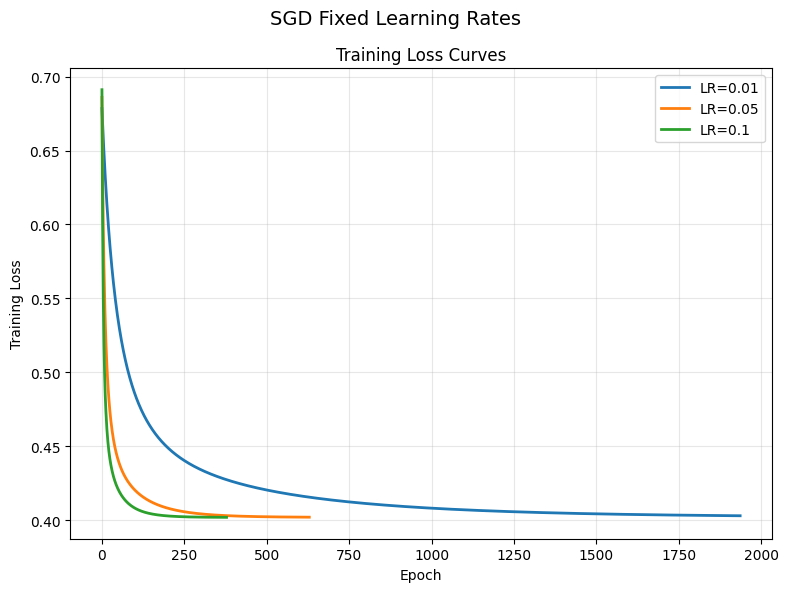

In [10]:
def analyze_sgd_results(results):
    learning_rates = list(results.keys())

    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle("SGD Fixed Learning Rates", fontsize=14)

    for lr in learning_rates:
        history = results[lr]["training_history"]
        ax.plot(
            history["epoch_history"],
            history["loss_history"],
            label=f"LR={lr}",
            linewidth=2,
        )

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    ax.set_title("Training Loss Curves")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


analyze_sgd_results(sgd_lr_results)

# Archive

In [ ]:
# Analyze and visualize SGD results
def analyze_sgd_results(results):
    """
    Analyze and visualize the SGD results across different learning rates.
    """
    # Create comprehensive comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(
        "SGD Performance Analysis Across Different Learning Rates", fontsize=16
    )

    # Extract data for plotting
    learning_rates = list(results.keys())
    final_epochs = [
        results[lr]["training_history"]["final_epoch"] for lr in learning_rates
    ]
    final_losses = [
        results[lr]["training_history"]["final_loss"] for lr in learning_rates
    ]
    val_accuracies = [results[lr]["val_metrics"]["accuracy"] for lr in learning_rates]
    test_accuracies = [results[lr]["test_metrics"]["accuracy"] for lr in learning_rates]
    training_times = [results[lr]["total_time"] for lr in learning_rates]
    early_stopped = [
        results[lr]["training_history"]["stopped_early"] for lr in learning_rates
    ]

    # Plot 1: Loss curves for all learning rates
    ax1 = axes[0, 0]
    for lr in learning_rates:
        history = results[lr]["training_history"]
        ax1.plot(
            history["epoch_history"],
            history["loss_history"],
            label=f"LR={lr}",
            linewidth=2,
        )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Training Loss")
    ax1.set_title("Training Loss Curves")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Final epochs comparison
    ax2 = axes[0, 1]
    colors = ["red" if stopped else "blue" for stopped in early_stopped]
    bars = ax2.bar(range(len(learning_rates)), final_epochs, color=colors, alpha=0.7)
    ax2.set_xlabel("Learning Rate")
    ax2.set_ylabel("Final Epoch")
    ax2.set_title("Training Duration (Red = Early Stopped)")
    ax2.set_xticks(range(len(learning_rates)))
    ax2.set_xticklabels([str(lr) for lr in learning_rates])
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, epoch in zip(bars, final_epochs):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            str(epoch),
            ha="center",
            va="bottom",
        )

    # Plot 3: Final loss comparison
    ax3 = axes[0, 2]
    ax3.bar(range(len(learning_rates)), final_losses, alpha=0.7, color="green")
    ax3.set_xlabel("Learning Rate")
    ax3.set_ylabel("Final Training Loss")
    ax3.set_title("Final Training Loss")
    ax3.set_xticks(range(len(learning_rates)))
    ax3.set_xticklabels([str(lr) for lr in learning_rates])
    ax3.grid(True, alpha=0.3)

    # Plot 4: Validation accuracy comparison
    ax4 = axes[1, 0]
    ax4.bar(range(len(learning_rates)), val_accuracies, alpha=0.7, color="orange")
    ax4.set_xlabel("Learning Rate")
    ax4.set_ylabel("Validation Accuracy")
    ax4.set_title("Validation Accuracy")
    ax4.set_xticks(range(len(learning_rates)))
    ax4.set_xticklabels([str(lr) for lr in learning_rates])
    ax4.grid(True, alpha=0.3)

    # Plot 5: Test accuracy comparison
    ax5 = axes[1, 1]
    ax5.bar(range(len(learning_rates)), test_accuracies, alpha=0.7, color="purple")
    ax5.set_xlabel("Learning Rate")
    ax5.set_ylabel("Test Accuracy")
    ax5.set_title("Test Accuracy")
    ax5.set_xticks(range(len(learning_rates)))
    ax5.set_xticklabels([str(lr) for lr in learning_rates])
    ax5.grid(True, alpha=0.3)

    # Plot 6: Training time comparison
    ax6 = axes[1, 2]
    ax6.bar(range(len(learning_rates)), training_times, alpha=0.7, color="brown")
    ax6.set_xlabel("Learning Rate")
    ax6.set_ylabel("Training Time (seconds)")
    ax6.set_title("Training Time")
    ax6.set_xticks(range(len(learning_rates)))
    ax6.set_xticklabels([str(lr) for lr in learning_rates])
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed summary
    print("\nDetailed SGD Performance Summary")
    print("=" * 80)
    print(
        f"{'LR':<6} {'Epochs':<8} {'Early Stop':<12} {'Train Loss':<12} {'Val Acc':<10} {'Test Acc':<10} {'Time(s)':<8}"
    )
    print("-" * 80)

    for lr in learning_rates:
        result = results[lr]
        epochs = result["training_history"]["final_epoch"]
        early_stop = "Yes" if result["training_history"]["stopped_early"] else "No"
        train_loss = result["train_metrics"]["loss"]
        val_acc = result["val_metrics"]["accuracy"]
        test_acc = result["test_metrics"]["accuracy"]
        time_taken = result["total_time"]

        print(
            f"{lr:<6} {epochs:<8} {early_stop:<12} {train_loss:<12.6f} {val_acc:<10.4f} {test_acc:<10.4f} {time_taken:<8.2f}"
        )

    # Find best performing learning rate
    best_lr_val = max(
        learning_rates, key=lambda lr: results[lr]["val_metrics"]["accuracy"]
    )
    best_lr_test = max(
        learning_rates, key=lambda lr: results[lr]["test_metrics"]["accuracy"]
    )

    print(
        f"\nBest Learning Rate by Validation Accuracy: {best_lr_val} ({results[best_lr_val]['val_metrics']['accuracy']:.4f})"
    )
    print(
        f"Best Learning Rate by Test Accuracy: {best_lr_test} ({results[best_lr_test]['test_metrics']['accuracy']:.4f})"
    )

    return best_lr_val, best_lr_test


# Analyze results
best_lr_val, best_lr_test = analyze_sgd_results(sgd_lr_results)

In [ ]:
# Analyze and visualize SGD comparison results
def analyze_sgd_comparison(results):
    """
    Comprehensive analysis and visualization of SGD methods comparison.
    """
    print("\nComprehensive SGD Methods Analysis")
    print("=" * 80)
    
    # Separate fixed and backtracking results
    fixed_results = {k: v for k, v in results.items() if v['optimizer_type'] == 'fixed'}
    backtrack_results = {k: v for k, v in results.items() if v['optimizer_type'] == 'backtrack'}
    
    # Create comprehensive comparison plots
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Loss curves comparison (top left)
    ax1 = plt.subplot(3, 3, 1)
    for key, result in results.items():
        history = result['training_history']
        label = result['method']
        linestyle = '-' if result['optimizer_type'] == 'fixed' else '--'
        ax1.plot(history['epoch_history'], history['loss_history'], 
                label=label, linewidth=2, linestyle=linestyle)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Loss Curves: Fixed vs Backtracking')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Final epochs comparison (top center)
    ax2 = plt.subplot(3, 3, 2)
    methods = [result['method'] for result in results.values()]
    final_epochs = [result['training_history']['final_epoch'] for result in results.values()]
    colors = ['blue' if result['optimizer_type'] == 'fixed' else 'red' for result in results.values()]
    
    bars = ax2.bar(range(len(methods)), final_epochs, color=colors, alpha=0.7)
    ax2.set_xlabel('Method')
    ax2.set_ylabel('Final Epoch')
    ax2.set_title('Training Duration (Blue=Fixed, Red=Backtrack)')
    ax2.set_xticks(range(len(methods)))
    ax2.set_xticklabels(methods, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, epoch in zip(bars, final_epochs):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                str(epoch), ha='center', va='bottom')
    
    # Plot 3: Test accuracy comparison (top right)
    ax3 = plt.subplot(3, 3, 3)
    test_accuracies = [result['test_metrics']['accuracy'] for result in results.values()]
    ax3.bar(range(len(methods)), test_accuracies, color=colors, alpha=0.7)
    ax3.set_xlabel('Method')
    ax3.set_ylabel('Test Accuracy')
    ax3.set_title('Test Accuracy Comparison')
    ax3.set_xticks(range(len(methods)))
    ax3.set_xticklabels(methods, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Step size evolution for backtracking methods (middle left)
    ax4 = plt.subplot(3, 3, 4)
    for key, result in backtrack_results.items():
        history = result['training_history']
        ax4.plot(history['epoch_history'], history['step_size_history'], 
                label=result['method'], linewidth=2)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Step Size')
    ax4.set_title('Step Size Evolution (Backtracking Methods)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')
    
    # Plot 5: Average backtracking iterations (middle center)
    ax5 = plt.subplot(3, 3, 5)
    backtrack_methods = [result['method'] for result in backtrack_results.values()]
    avg_backtracks = [result['training_history']['avg_backtrack_iterations'] for result in backtrack_results.values()]
    ax5.bar(range(len(backtrack_methods)), avg_backtracks, color='red', alpha=0.7)
    ax5.set_xlabel('Backtracking Method')
    ax5.set_ylabel('Avg Backtrack Iterations')
    ax5.set_title('Average Backtracking Iterations')
    ax5.set_xticks(range(len(backtrack_methods)))
    ax5.set_xticklabels(backtrack_methods, rotation=45, ha='right')
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Training time comparison (middle right)
    ax6 = plt.subplot(3, 3, 6)
    training_times = [result['total_time'] for result in results.values()]
    ax6.bar(range(len(methods)), training_times, color=colors, alpha=0.7)
    ax6.set_xlabel('Method')
    ax6.set_ylabel('Training Time (seconds)')
    ax6.set_title('Training Time Comparison')
    ax6.set_xticks(range(len(methods)))
    ax6.set_xticklabels(methods, rotation=45, ha='right')
    ax6.grid(True, alpha=0.3)
    
    # Plot 7: Loss convergence (first 100 epochs) (bottom left)
    ax7 = plt.subplot(3, 3, 7)
    for key, result in results.items():
        history = result['training_history']
        epochs_subset = history['epoch_history'][:100]
        loss_subset = history['loss_history'][:100]
        if len(epochs_subset) > 0:
            linestyle = '-' if result['optimizer_type'] == 'fixed' else '--'
            ax7.plot(epochs_subset, loss_subset, 
                    label=result['method'], linewidth=2, linestyle=linestyle)
    ax7.set_xlabel('Epoch')
    ax7.set_ylabel('Training Loss')
    ax7.set_title('Early Convergence (First 100 Epochs)')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # Plot 8: Final loss comparison (bottom center)
    ax8 = plt.subplot(3, 3, 8)
    final_losses = [result['training_history']['final_loss'] for result in results.values()]
    ax8.bar(range(len(methods)), final_losses, color=colors, alpha=0.7)
    ax8.set_xlabel('Method')
    ax8.set_ylabel('Final Training Loss')
    ax8.set_title('Final Loss Comparison')
    ax8.set_xticks(range(len(methods)))
    ax8.set_xticklabels(methods, rotation=45, ha='right')
    ax8.grid(True, alpha=0.3)
    
    # Plot 9: Efficiency metric (accuracy per second) (bottom right)
    ax9 = plt.subplot(3, 3, 9)
    efficiency = [result['test_metrics']['accuracy'] / result['total_time'] 
                 for result in results.values()]
    ax9.bar(range(len(methods)), efficiency, color=colors, alpha=0.7)
    ax9.set_xlabel('Method')
    ax9.set_ylabel('Accuracy / Time')
    ax9.set_title('Efficiency (Accuracy per Second)')
    ax9.set_xticks(range(len(methods)))
    ax9.set_xticklabels(methods, rotation=45, ha='right')
    ax9.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary table
    print(f"\nDetailed Performance Summary")
    print("-" * 120)
    print(f"{'Method':<20} {'Type':<10} {'Epochs':<8} {'Final Loss':<12} {'Test Acc':<10} {'Time(s)':<8} {'Efficiency':<12}")
    print("-" * 120)
    
    for key, result in results.items():
        method = result['method']
        opt_type = result['optimizer_type'].capitalize()
        epochs = result['training_history']['final_epoch']
        final_loss = result['training_history']['final_loss']
        test_acc = result['test_metrics']['accuracy']
        time_taken = result['total_time']
        efficiency = test_acc / time_taken
        
        print(f"{method:<20} {opt_type:<10} {epochs:<8} {final_loss:<12.6f} {test_acc:<10.4f} {time_taken:<8.2f} {efficiency:<12.4f}")
    
    # Additional analysis for backtracking methods
    if backtrack_results:
        print(f"\nBacktracking Methods Additional Details")
        print("-" * 100)
        print(f"{'Method':<20} {'Init Step':<10} {'Final Step':<12} {'Avg Step':<12} {'Avg Backtrack':<15}")
        print("-" * 100)
        
        for key, result in backtrack_results.items():
            method = result['method']
            init_step = result['training_history']['initial_learning_rate']
            final_step = result['training_history']['final_step_size']
            avg_step = result['training_history']['avg_step_size']
            avg_backtrack = result['training_history']['avg_backtrack_iterations']
            
            print(f"{method:<20} {init_step:<10.6f} {final_step:<12.6f} {avg_step:<12.6f} {avg_backtrack:<15.2f}")
    
    # Find best methods
    best_accuracy = max(results.keys(), key=lambda k: results[k]['test_metrics']['accuracy'])
    best_efficiency = max(results.keys(), key=lambda k: results[k]['test_metrics']['accuracy'] / results[k]['total_time'])
    fastest_convergence = min(results.keys(), key=lambda k: results[k]['training_history']['final_epoch'])
    
    print(f"\nBest Performing Methods:")
    print(f"Best Accuracy: {results[best_accuracy]['method']} ({results[best_accuracy]['test_metrics']['accuracy']:.4f})")
    print(f"Best Efficiency: {results[best_efficiency]['method']} ({results[best_efficiency]['test_metrics']['accuracy'] / results[best_efficiency]['total_time']:.4f} acc/sec)")
    print(f"Fastest Convergence: {results[fastest_convergence]['method']} ({results[fastest_convergence]['training_history']['final_epoch']} epochs)")
    
    return results

# Analyze the comparison results
analyzed_results = analyze_sgd_comparison(sgd_comparison_results)